# Lecture 7: Estimating with Subsampling

## CS4787 — Principles of Large-Scale Machine Learning Systems

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\norm}[1]{\left\|#1\right\|}$
$\newcommand{\Exv}[1]{\mathbf{E}\left[#1\right]}$
$\newcommand{\Prob}[1]{\mathbf{P}\left(#1\right)}$
$\newcommand{\Var}[1]{\operatorname{Var}\left(#1\right)}$
$\newcommand{\Abs}[1]{\left|#1\right|}$

In [1]:
import numpy
import scipy
import matplotlib
from matplotlib import pyplot
import time

matplotlib.rcParams.update({'font.size': 18})

## Announcements

**Prelim Exam This Thursday**: Take-home, open-book, open-computer exam covering everything we've done up to that point (but with a focus on things that have appeared in problem sets and programming assignments). 24 hours, starting from the posted exam time. Submit your solutions on gradescope.

If you have an accommodation that would get you extra time on in-class timed exams, I have been told that this *generally does not apply* to take-home exams like this one, so I will not be automatically granting you any extra time based on your existing SDS letter. If you think this is in error as regards your particular SDS accommodation, please let me know ASAP.

**No programming assignment today.** Because of the prelim, we will leave off on assigning PA2 until next Monday.

## Recall: The empirical risk.

Suppose we have a dataset $\mathcal{D} = \{ (x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n) \}$, where $x_i \in \mathcal{X}$ is an example and $y_i \in \mathcal{Y}$ is a label.

* Let $h: \mathcal{X} \rightarrow \mathcal{Y}$ be a hypothesized model (mapping from examples to labels) we are trying to evaluate.

* Let $L: \mathcal{Y} \times \mathcal{Y} \rightarrow \mathbb{R}$ be a \emph{loss function} which measures how different two labels are.

The *empirical risk* is

$$R(h) = \frac{1}{n} \sum_{i=1}^n L(h(x_i), y_i).$$

We need to compute the empirical risk a lot during training, both during validation (and hyperparameter optimization) and testing, so it's nice if we can do it fast.
* But the cost will certainly be proportional to $n$, the number of training examples
* Usually is also proportional to the number of parameters for parameterized hypotheses.

<div style="font-size:200%;color:forestgreen;font-weight:bold;text-align:center">Question: what if $n$ is very large? Must we spend a long time computing the empirical risk?</div>

### This sort of problem is not unique to machine learning: An Example from Science

Suppose we want to know the average number of dogs kept as pets in an American household.

One way to do this is to call up all 100 million or so American households and ask them how many dogs they have, then compute the average.

<span style="font-size:100%;color:forestgreen;font-weight:bold;">Is this efficient? Is this an effective way to allocate the resources we have to do science?</span>

<span style="font-size:100%;color:forestgreen;font-weight:bold;">How can we gain knowledge of the average more efficiently?</span>

<div style="font-size:200%;color:blue;font-weight:bold;text-align:center">Answer: We can approximate the whole dataset/population using subsampling.</div>

* This is another application of the second of the three principles of scalable ML we discussed in the first lecture!

### Subsampling for the Empirical Risk: The Main idea

Let $\tilde i$ be a random index drawn uniformly from $\{1, \ldots, n\}$, and let $Z$ be a random variable that takes on the value $L(h(x_{\tilde i}), y_{\tilde i})$.
That is, $Z$ is the result of sampling a single element from the sum in the formula for the empirical risk. By the definition of expected value:

\begin{align*}
\Exv{Z} &= \sum_{i=1}^n \mathbf{P}(\tilde i = i) \cdot L(h(x_i), y_i)
\\ &= \frac{1}{n} \sum_{i=1}^n L(h(x_i), y_i) = R(h).
\end{align*}

If we sample a bunch of independent identically distributed random variables $Z_1, Z_2, \ldots, Z_K$ identical to $Z$, then their average will be a good approximation of the empirical risk. That is,

$$S_K = \frac{1}{K} \sum_{k=1}^K Z_k \approx R(h).$$

<div style="font-size:200%;color:forestgreen;font-weight:bold;text-align:center">Question: what is the cost of computing this approximation, supposing each evaluation $L(h(x_i),y_i)$ can be done in $O(1)$ time? Does it depend on $n$?</div>

$O(K)$

This is an instance of the statistical principle that **the average of a collection of independent random variables tends to cluster around their mean**.
* This is called "concentration"


We can formalize this asymptotically with the *strong law of large numbers*, which says that

$$\Prob{\lim_{K \rightarrow \infty} \frac{1}{K} \sum_{k=1}^K Z_k = \Exv{Z} = R(h)} = 1,$$

i.e. that as the number of samples approaches infinity, their average converges to their mean almost surely.

<div style="font-size:200%;color:darkmagenta;font-weight:bold;text-align:center">DEMO</div>

<div style="font-size:150%;color:darkred;font-weight:bold;text-align:center">Problem: the law of large numbers tells us our approximations will be asymptotically accurate...but not what the distribution of the average will look like.</div>

To get this, we use the **central limit theorem**, which characterizes the behavior of large sums of independent variables. If our random variables $Z$ have bounded mean and variance, then

$$\sqrt{K} \left( \frac{1}{K} \sum_{k=1}^K Z_k - \Exv{Z} \right) \text{ converges in distribution to } \mathcal{N}(0, \Var{Z}) \text{ as } K \rightarrow \infty.$$

* Here, $\mathcal{N}(\mu, \sigma^2)$ denotes the normal distribution with mean $\mu$ and variance $\sigma^2$.

Takeaway: **pretty much any large enough average is going to look like a bell curve.**

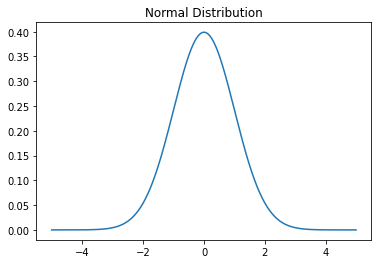

In [2]:
z = numpy.arange(-5,5,0.01)
pz = numpy.exp(-(z**2)/2) / numpy.sqrt(2*numpy.pi)
pyplot.plot(z,pz);
pyplot.title("Normal Distribution");

Takeaway: **pretty much any large enough average is going to look like a bell curve.**

<div style="font-size:150%;color:darkred;font-weight:bold;text-align:center">Problem: the law of large numbers and the central limit theorem tell us our approximations will be accurate in the limit...but we run our algorithms for a finite amount of time!</div>

Need some way to tell how many samples we need to average to get approximations we can be confident in.

To address this problem, we use something called a *concentration inequality*: a formula that lets us bound for a *finite* sum what the probability it will diverge from its expected value will be.

## Loads of Applications!

Concentration inequalities and subsampling aren't just about making machine learning more efficient. They also *drive statistical science*. This is how we can do surveys of the population and be confident that our estimates are accurate. And applying this incorrectly can be very embarrasing!

<img src="https://upload.wikimedia.org/wikipedia/commons/0/09/Dewey_Defeats_Truman.jpg" width="60%"/>

* E.g. in this setup, $Z$ would be a random variable in $\{0,1\}$, where $1$ would indicate a vote for Truman and $0$ would indicate a vote for Dewey, and the way we sample a $Z$ is to call up a random voter and ask them who they voted for. We then want to know: how likely is it that our estimate $\frac{1}{K} \sum_{k=1}^K Z_k$ differs by at most some amount from the actual fraction of voters who voted for Truman?

Another way to look at these sorts of question is: how large do I need to make my sample to be confident in my estimate to within a specified margin of error?

Other applications in medicine and drug trials.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Clinical_Trial_Participant_Receives_Injection_%2834033294061%29.jpg/424px-Clinical_Trial_Participant_Receives_Injection_%2834033294061%29.jpg" width="30%"/>

* E.g. in this setup, $Z$ could be a random variable indicating the duration of symptoms of a patient from a population given some tested drug, and the way we sample a $Z$ is to give the drug to a patient. We want to know: how likely is it that our estimate $\frac{1}{K} \sum_{k=1}^K Z_k$ differs by at most some amount from the true average symptom duration that would be experienced by people receiving this drug?

Note that in practice, there are many other sources of error we also need to take into account (e.g. the random variable we're sampling may have some bias relative to the thing we're trying to measure), but concentration of some sort is usually at the core of the analysis!

## Markov's Inequality

The granddaddy of all concentration inequalities is **Markov's inequality**, which states that if $S$ is a non-negative random variable with finite expected value, then for any constant $a > 0$,

$$\Prob{S \ge a} \le \frac{\Exv{S}}{a}.$$

### Markov's Inequality: A Simple Proof

\begin{align*}
\Exv{S} &= \Prob{S \ge a} \cdot \Exv{S | S \ge a} + \Prob{S < a} \cdot \Exv{S | S < a}
\\&\ge \Prob{S \ge a} \cdot a + 0 \cdot \Exv{S | S < a}
\\&= \Prob{S \ge a} \cdot a,
\end{align*}

...from which it immediately follows that...

$$\Prob{S \ge a} \le \frac{\Exv{S}}{a}.$$


## Markov's Inequality

The granddaddy of all concentration inequalities is **Markov's inequality**, which states that if $S$ is a non-negative random variable with finite expected value, then for any constant $a > 0$,

$$\Prob{S \ge a} \le \frac{\Exv{S}}{a}.$$

What bound do we get for our empirical risk sum using Markov's inequality if we are using a 0-1 loss (so $0 \le Z \le 1$)? Is this a useful bound?

$$\color{green}{\Prob{\frac{1}{K} \sum_{k=1}^K Z_k \ge a} \le \frac{R(h)}{a}}$$

...

## Chebyshev's Inequality

A perhaps-more-useful concentration inequality is Chebyshev's inequality. This inequality uses the variance of the random variable, in addition to its expected value, to bound its distance from its expected value.
If $S$ is a non-negative random variable with finite expected value and variance, then for any constant $a > 0$,

$$\Prob{\Abs{S - \Exv{S}} \ge a} \le \frac{\Var{S}}{a^2}.$$

### Chebyshev's Inequality: A Simple Proof

Apply Markov's inequality to the random variable $Y = (S - \Exv{S})^2$. Since it's the square of something, it's always non-negative, so we can apply Markov's inequality.

$$\Prob{Y \ge a} \le \frac{\Exv{Y}}{a}.$$

Substituting $a \rightarrow a^2$ and substituting the definition of $Y$,

$$\Prob{(S - \Exv{S})^2 \ge a^2} \le \frac{\Exv{(S - \Exv{S})^2}}{a^2} = \frac{\Var{S}}{a^2}.$$

## Chebyshev's Inequality

A perhaps-more-useful concentration inequality is Chebyshev's inequality. This inequality uses the variance of the random variable, in addition to its expected value, to bound its distance from its expected value.
If $S$ is a non-negative random variable with finite expected value and variance, then for any constant $a > 0$,

$$\Prob{\Abs{S - \Exv{S}} \ge a} \le \frac{\Var{Z}}{a^2}.$$

What bound do we get for our empirical risk sum using Chebyshev's inequality if we are using a 0-1 loss (so $0 \le Z \le 1$)? Is this a useful bound?

$$\color{green}{\Prob{\Abs{ \frac{1}{K} \sum_{k=1}^K Z_k - R(h) } \ge a} \le \frac{1}{4K a^2}}$$

$$\Var{S_K} = \Var{ \frac{1}{K} \sum_{k=1}^K Z_k } = \frac{1}{K^2} \Var{ \sum_{k=1}^K Z_k } = \frac{1}{K^2} \sum_{k=1}^K \Var{ Z_k } = \frac{\Var{Z}}{K}$$

$$p = \frac{1}{4 K a^2} \rightarrow a = \sqrt{\frac{1}{4Kp}}$$

$$\Prob{\Abs{ \frac{1}{K} \sum_{k=1}^K Z_k - R(h) } \ge \sqrt{\frac{1}{4Kp}}} \le p$$

$$\Var{Z} = \Var{Z - \frac{1}{2}} \le \Exv{\left(Z - \frac{1}{2}\right)^2} \le \frac{1}{4}$$

$$\Var{Z} \le \Exv{Z^2} \le 1$$

**Activity:** if we want to estimate the empirical risk with 0-1 loss to within $10\%$ error (i.e. $\Abs{S_K - R(h)} \le 10\%$) with probability $99\%$, how many samples $K$ do we need to average up if we use this Chebyshev's inequality bound?

...

<div style="font-size:150%;color:darkred;font-weight:bold;text-align:left">Problem: this is just the number of samples we need to evaluate the empirical risk of a single model.</div>

But we often want to approximate the empirical risk many times during training, either to validate a model or to monitor convergence of training loss.

* This also happens in statistical applications: we want to make sure we can be confident that *all* of our estimates are accurate at once if we want to draw conclusions from multiple estimates. For example, if we want to conclude that one drug is better than another, we need to be confident simultaneously in the estimates we are making for both drugs.

For example, suppose we have $M$ hypotheses we want to validate ($h^{(1)}, \ldots, h^{(M)}$), and we use independent subsamples ($S_K^{(1)}, \ldots, S_K^{(M)}$, each of size $K$) to approximate the empirical risk for each of them.
What bound can we get using Chebyshev's inequality on the probability that **all** $M$ of our independent approximations are within a distance $a$ of their true empirical risk?


$$\color{green}{\Prob{\Abs{ \frac{1}{K} \sum_{k=1}^K Z_k - R(h) } \ge a} \le \frac{1}{4K a^2}}$$

$$\color{green}{\Prob{\Abs{S_K^{(m)} - R(h^{(m)})} \le a \text{ for all } m \in \{1,\ldots, M\}} \ge 1 - \frac{M}{4K a^2}}$$

Now if we want to estimate the empirical risk with 0-1 loss to within the same $10\%$ error rate with the same probability of $99\%$, but for all of $M = 100$ different hypotheses, how many samples do we need according to this Chebyshev bound?

$$\Prob{\Abs{S_K^{(m)} - R(h^{(m)})} \le a \text{ for all } m \in \{1,\ldots, M\}} = \prod_{m=1}^M \Prob{\Abs{S_K^{(m)} - R(h^{(m)})} \le a}$$

$$\Prob{\Abs{S_K^{(m)} - R(h^{(m)})} \le a \text{ for all } m \in \{1,\ldots, M\}} \ge \left( 1 - \frac{1}{4Ka^2} \right)^M \approx \exp\left( - \frac{1}{4Ka^2} \right)^M$$

**Takeaways:**

* We needed a lot more than we did for the one-hypothesis case.
* This seems to be a problem for training where we want to validate potentially thousands of models across potentially hundreds of epochs.
* The problem with Chebyshev's inequality: the probabilities we are getting are not that small. Since we know that the sums are approaching something like a Gaussian distribution, we'd expect the probability of diverging some amount from the expected value to decrease exponentially as $a$ increases, since this is what happens for a Gaussian. But Chebyshev's inequality only gives us a polynomial decrease.

## A Better Bound: Hoeffding's Inequality

Hoeffding's inequality states that if $Z_1, \ldots, Z_K$ are independent random variables, and

$$S_K = \frac{1}{K} \sum_{k=1}^K Z_k,$$

then if those variables are bound absolutely by $z_{\min} \le Z_k \le z_{\max}$, then

$$\Prob{ \Abs{ S_K - \Exv{S_K} } \ge a } \le 2 \exp\left( -\frac{2 K a^2}{(z_{\max} - z_{\min})^2} \right).$$

**Activity:** if we want to estimate the empirical risk with 0-1 loss to within $10\%$ error (i.e. $\Abs{S_K - R(h)} \le 10\%$) with probability $99\%$, how many samples $K$ do we need to average up if we use this Hoeffding's inequality bound?


...

What if we want to estimate the empirical risk with 0-1 loss to within the same $10\%$ error rate with the same probability of $99\%$, but for all of $M = 100$ different hypotheses. How many samples do we need according to this Hoeffding's inequality bound?

...

**Takeaway**: the Hoeffding's inequality bound is much tighter, and scales better with the number of times we want to estimate using subsampling. We can use this sort of bound to estimate the number of samples we need to use to estimate a sum like the empirical risk to within some level of accuracy with high probability.


## High-Level Message

Concentration inequalities...
* let you be confident that your subsampled estimate of the empirical risk is a "good" estimate, and
* tell you how many samples you need for to have a certain level of confidence.

This is useful not just for subsampling for efficiency, but also for bounding the errors that result from using a sample of test/validation data rather than the exact statistics on the true "real-world" test distribution.

And it has **loads of applications beyond machine learning**, to pretty much everywhere subsampling is used...and subsampling is *the* tool used in statistical science, from drug trials to politcal surveys.

* So you can use these sorts of tools in your data science work, even when you're not trying to learn anything!

### Post-script

**Many other concentration inequalities exist.**

* **Azuma's inequality** for when the components of your sum $Z_k$ are not independent.
* **Bennett's inequality** for when you want to take the variance into account in addition to the absolute bounds.